<a href="https://colab.research.google.com/github/Stealeristaken/Entry-Mid-Level-AI-Projects/blob/main/Preparing%20Data%20for%20Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q datasets transformers sentence_transformers faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.7 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
hf_token = userdata.get('huggingface')

In [ ]:
from datasets import load_dataset

dataset = load_dataset('garage-bAInd/Open-Platypus')
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [ ]:
dataset['train'].to_pandas()

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

#We are taking already trained tokenizers from our model to fit our dataset which is not tokenized yet.
tokenizer = AutoTokenizer.from_pretrained('NousResearch/Llama-2-7b-hf')

#We are gonna tokenize both rows (Features) to finetune our model.

instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset["train"]]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset["train"]]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]
#combined_token_counts

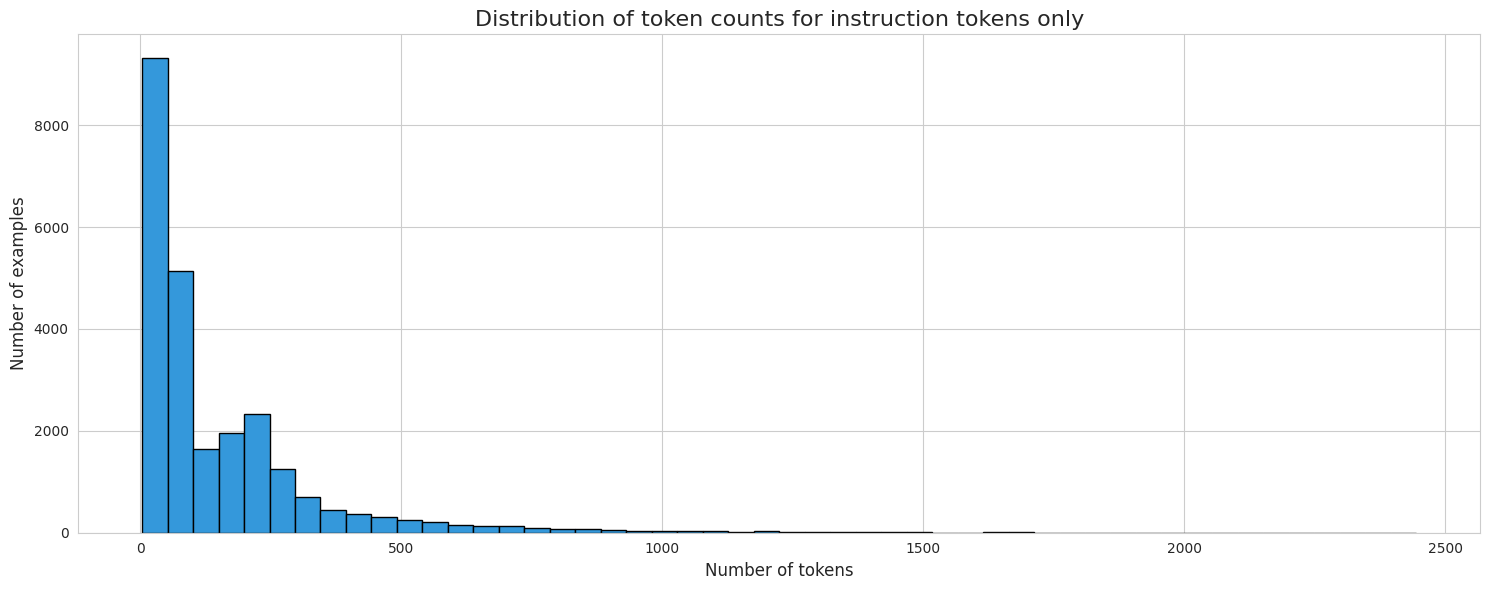

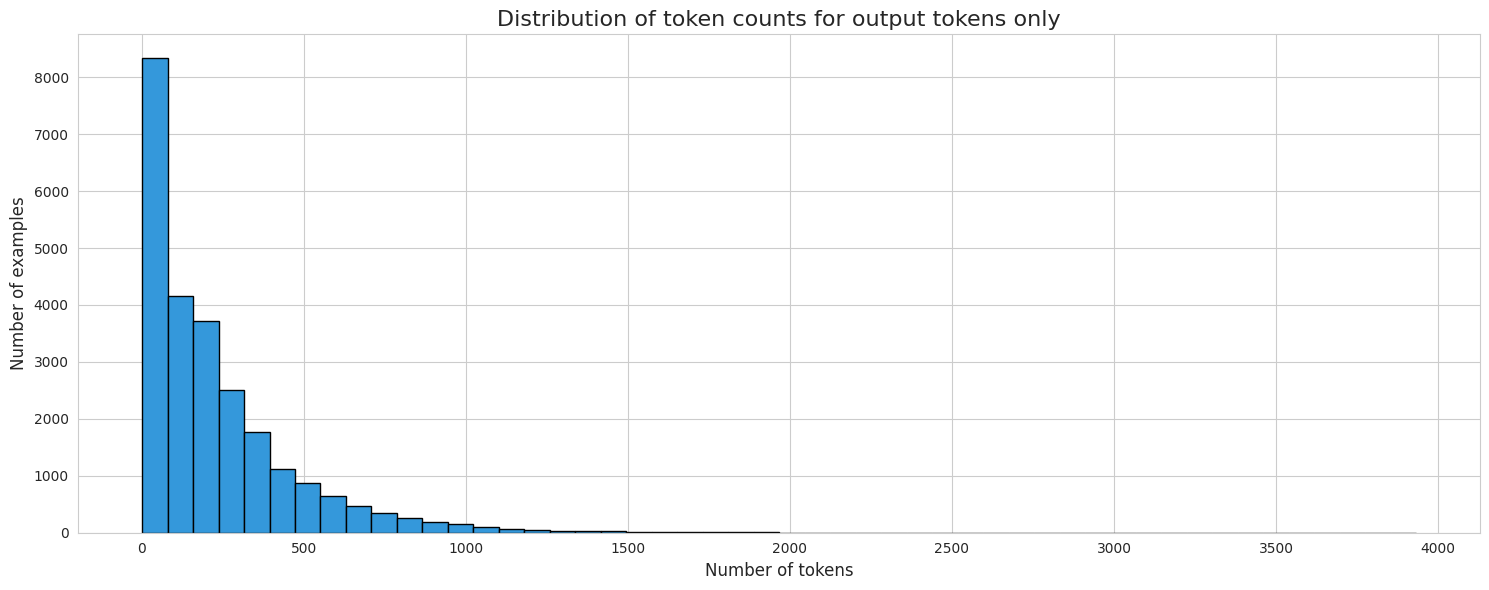

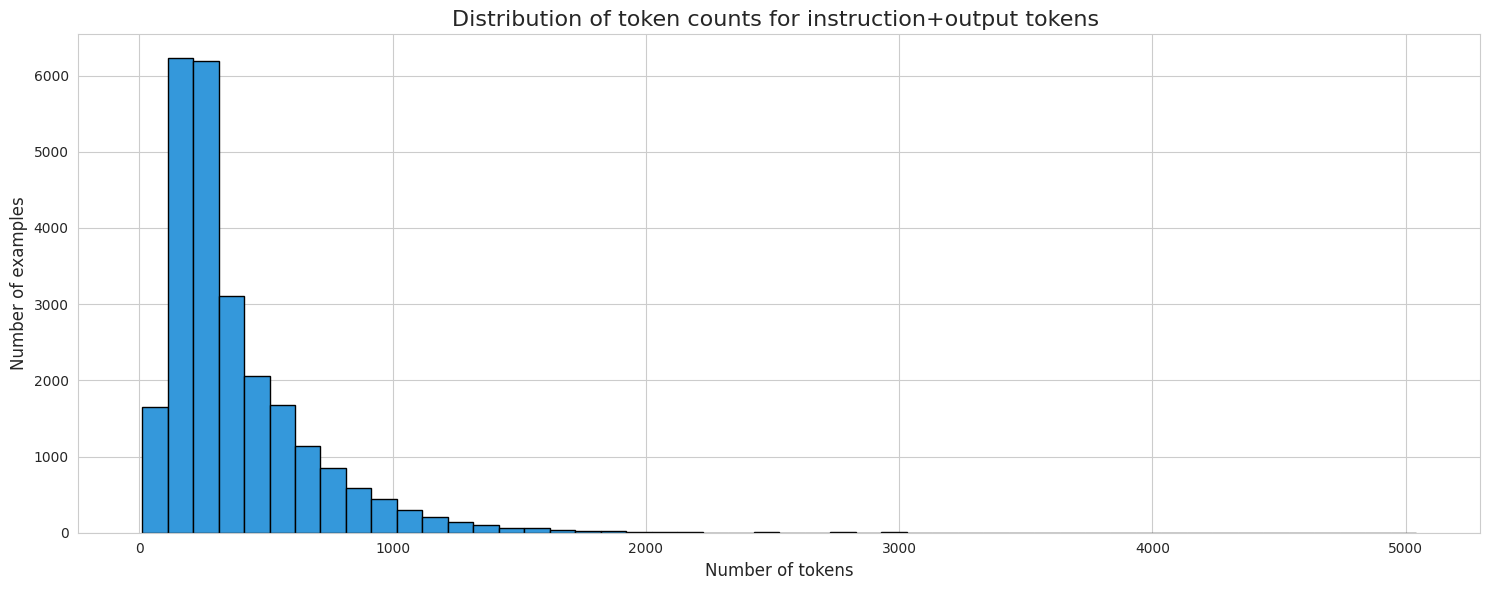

In [ ]:
def plot_distrubiton(token_counts, title):
  sns.set_style('whitegrid')
  plt.figure(figsize=(15,6))
  plt.hist(token_counts, bins=50, color = '#3498db', edgecolor='black')
  plt.title(title, fontsize=16)
  plt.xlabel("Number of tokens",fontsize=12)
  plt.ylabel("Number of examples",fontsize=12)
  plt.tight_layout()
  plt.show()


plot_distrubiton(instruction_token_counts, 'Distribution of token counts for instruction tokens only')
plot_distrubiton(output_token_counts, 'Distribution of token counts for output tokens only')
plot_distrubiton(combined_token_counts, 'Distribution of token counts for instruction+output tokens ')

# From our distribution tables we can see that we have to fitler out tokenizers that more than 2048 tokens (2048 is a district number that we choose from graphs)
### We can remove samples with more than 2048 tokens (please note that max context size of our model is 4096 (check for yours))

In [ ]:
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid indices : {len(valid_indices)}")
print(f"Number of indices to remove : {len(dataset['train'])-len(valid_indices)}")

Number of valid indices : 24895
Number of indices to remove : 31


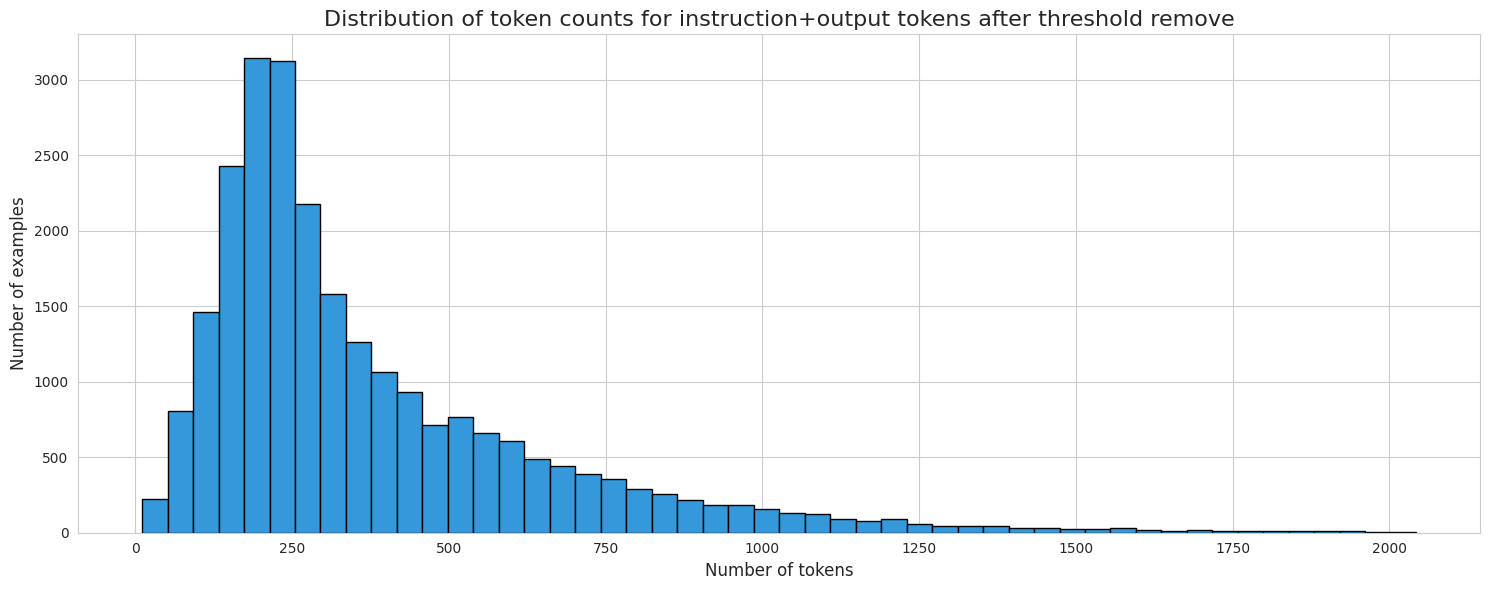

In [ ]:
dataset['train'] = dataset['train'].select(valid_indices)
token_counts = [combined_token_counts[i] for i in valid_indices]

plot_distrubiton(token_counts, "Distribution of token counts for instruction+output tokens after threshold remove")

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
  sentence_model=SentenceTransformer(model)
  outputs = [example["output"] for example in dataset["train"]]

  print("Converting text to embeddings...")
  embeddings = sentence_model.encode(outputs, show_progress_bar = True)
  dimension = embeddings.shape[1] #every embedding model has different shapes.
  index = faiss.IndexFlatIP(dimension)
  normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis = 1, keepdims=True)
  index.add(normalized_embeddings)

  print("Filtering out near-duplicates...")
  D, I  = index.search(normalized_embeddings, k=2)
  to_keep=[]
  for i in tqdm(range(len(embeddings)), desc="Filtering"):
    if D[i,1]<threshold:
      to_keep.append(i)
  dataset=dataset['train'].select(to_keep)
  return DatasetDict({'train': dataset})
deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

Converting text to embeddings...


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/24895 [00:00<?, ?it/s]

In [ ]:
print(len(dataset['train']))
print(len(deduped_dataset['train']))
print(len(dataset['train']) - len(deduped_dataset['train']))

24895
16489
8406


In [ ]:
def get_top_k_rows(dataset, token_counts, k):
  sorted_indices = sorted(range(len(token_counts)), key = lambda i: token_counts[i], reverse=True)
  top_k_indices = sorted_indices[:k]

  top_k_data = {
      'instruction': [dataset['train'][i]["instruction"] for i in top_k_indices],
      'output': [dataset['train'][i]["output"] for i in top_k_indices]
  }
  return Dataset.from_dict(top_k_data)

instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset["train"]]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset["train"]]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 1000
top_k_dataset = get_top_k_rows(dataset, combined_token_counts, k)
dataset = DatasetDict({"train": top_k_dataset})

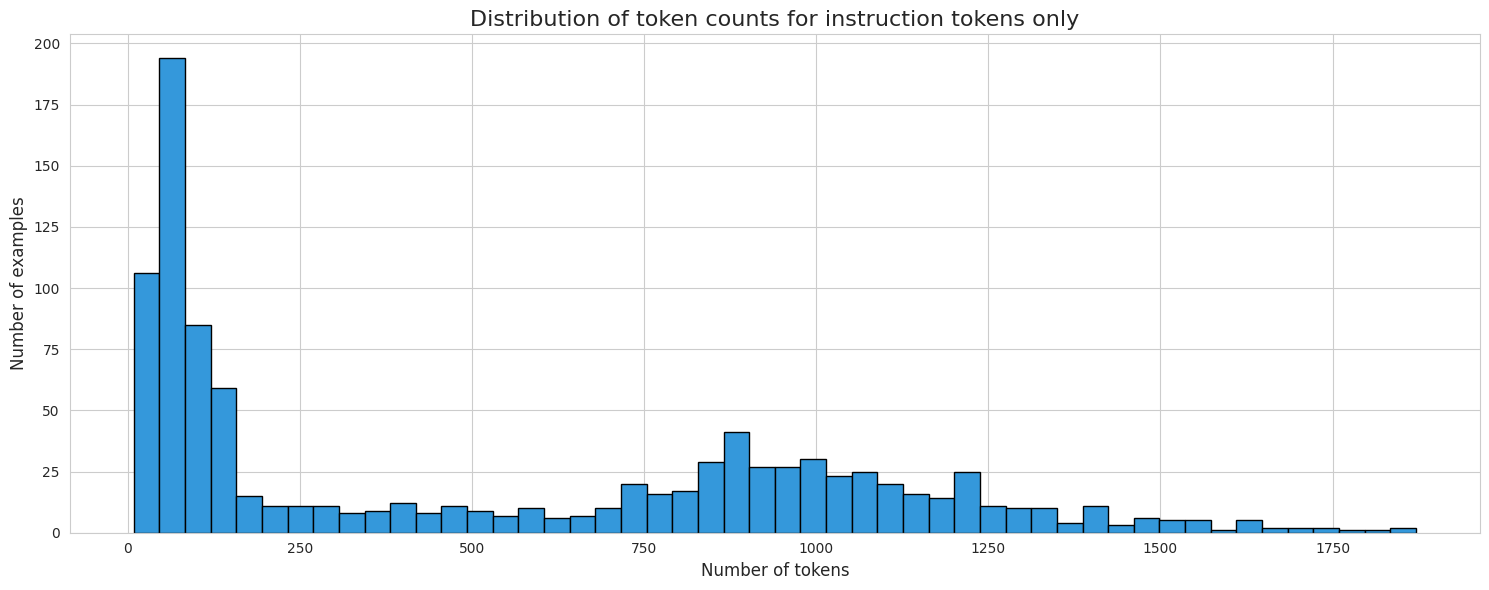

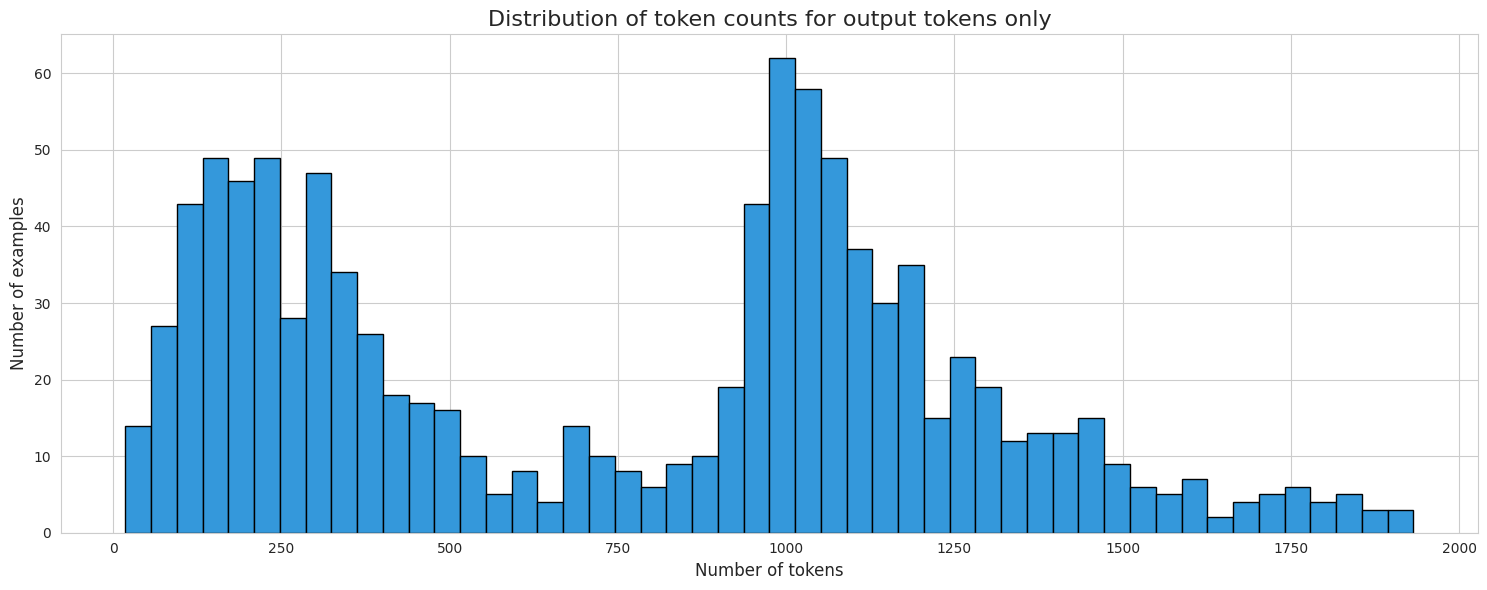

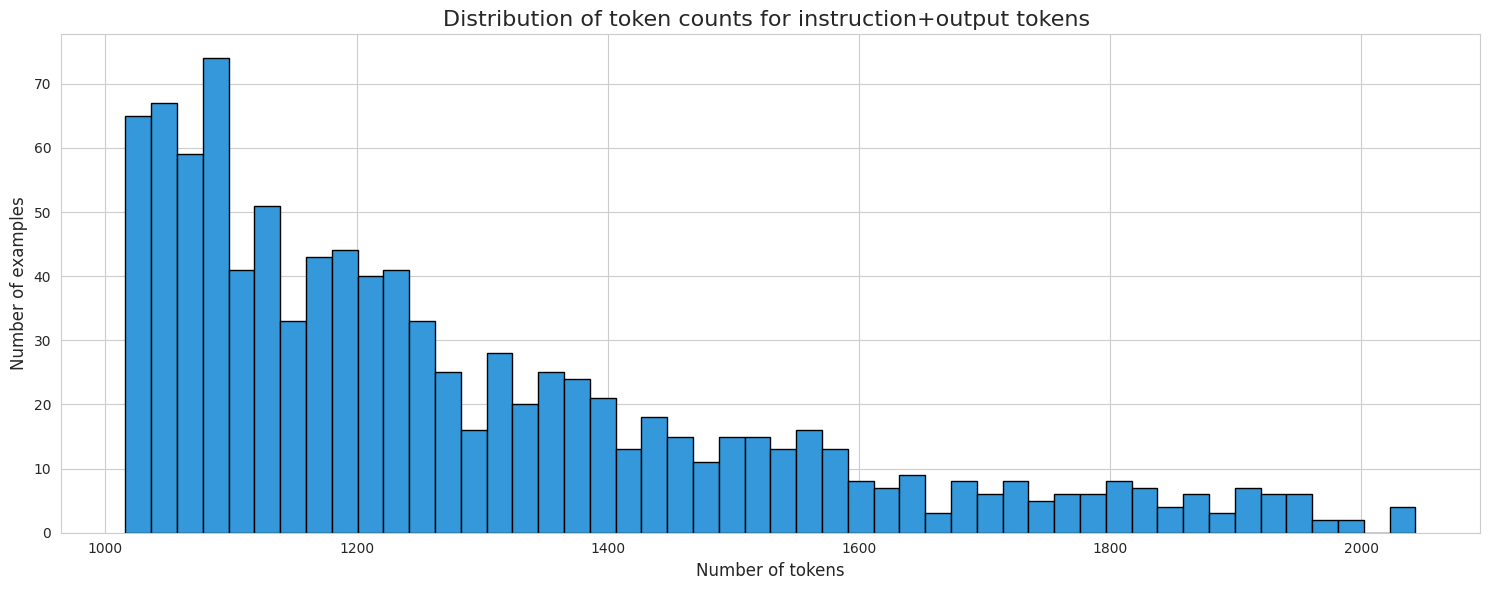

In [ ]:
plot_distrubiton(instruction_token_counts, 'Distribution of token counts for instruction tokens only')
plot_distrubiton(output_token_counts, 'Distribution of token counts for output tokens only')
plot_distrubiton(combined_token_counts, 'Distribution of token counts for instruction+output tokens ')

In [ ]:
dataset['train'].to_pandas()

,instruction,output
0,Let's come up with a rich and complex alien wo...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"Let\n$$p(x,y) = a_0 + a_1x + a_2y + a_3x^2 + a...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"Given the code below, refactor it, add comment...",Here is the refactored and commented version:\...
3,Find the area of the region described by $x \g...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,Let $P$ be the plane passing through the origi...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,BEGININPUT\nBEGINCONTEXT\ndate: 2023-07-15\nau...,The main changes made to the `autofocus.py` mo...
996,The setting is a gathering of friends discussi...,"Alice: ""Hey everyone, have you ever wondered h..."
997,I need to copy files from a computer folder to...,Sure! Here's a sample bash script that should ...
998,"In Cartesian space, three spheres centered at ...",The equation for the $xy$-plane is $z = 0.$\n\...


In [ ]:
def chat_template(example):
  example['instruction']= f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
  return example
dataset=dataset.map(chat_template)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
dataset['train'].to_pandas()

,instruction,output
0,### Instruction:\nLet's come up with a rich an...,Planet Name: Xylothar\n\nXylothar is a diverse...
1,"### Instruction:\nLet\n$$p(x,y) = a_0 + a_1x +...","Observe that \begin{align*}\np(0,0) &= a_0 = ..."
2,"### Instruction:\nGiven the code below, refact...",Here is the refactored and commented version:\...
3,### Instruction:\nFind the area of the region ...,"Let $n = \lfloor x \rfloor,$ and let $\{x\} = ..."
4,### Instruction:\nLet $P$ be the plane passing...,Let $\mathbf{v} = \begin{pmatrix} x \\ y \\ z ...
...,...,...
995,### Instruction:\nBEGININPUT\nBEGINCONTEXT\nda...,The main changes made to the `autofocus.py` mo...
996,### Instruction:\nThe setting is a gathering o...,"Alice: ""Hey everyone, have you ever wondered h..."
997,### Instruction:\nI need to copy files from a ...,Sure! Here's a sample bash script that should ...
998,"### Instruction:\nIn Cartesian space, three sp...",The equation for the $xy$-plane is $z = 0.$\n\...


In [ ]:
dataset.push_to_hub("mini-platypus-tryout", token=hf_token, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ardaorcun/mini-platypus-tryout/commit/60e0d5c6b7584026177f7aa39b4e58f98ad15385', commit_message='Upload dataset', commit_description='', oid='60e0d5c6b7584026177f7aa39b4e58f98ad15385', pr_url=None, pr_revision=None, pr_num=None)